# Problema de Optimización No Lineal Irrestricta: Algoritmos BFGS vs Región de Confianza

Este notebook compara dos algoritmos de optimización: 
BFGS, un método Quasi-Newton de aproximación Hessiana, y 
Región de Confianza, un algoritmo robusto con restricción de región

El análisis realiza búsqueda exhaustiva desde 441 puntos iniciales distribuidos en [-100, 100]²

## Configuración y Definiciones

Importaciones de bibliotecas, definición de la función objetivo y del generador de puntos iniciales.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [2]:
# Función objetivo: f(x,y) = sin(x**2 + y**2) / 10 + sqrt(log(x**2 + y**2 + 1) + 1)
def f(x):
    x_val, y_val = x[0], x[1]
    term = x_val**2 + y_val**2
    return np.sin(term) / 10 + np.sqrt(np.log(term + 1) + 1)

In [3]:
# Genera puntos iniciales de la forma (10*i, 10*j)
def generate_initial_points():
    starting_points = {}
    for i in range(-10, 11):
        for j in range(-10, 11):
            x = 10 * i
            y = 10 * j
            point_name = f'Grid({x:4d},{y:4d})'
            starting_points[point_name] = np.array([float(x), float(y)])
    return starting_points

starting_points = generate_initial_points()

In [4]:
class OptimizationTracker:
    def __init__(self, name):
        self.name = name
        self.iterations = []
        self.step_sizes = []
        self.function_values = []
        self.positions = []
    
    # Registra la posición actual y valor de función
    def record(self, x, f_val):
        if len(self.positions) > 0:
            step_size = np.linalg.norm(x - self.positions[-1])
            self.step_sizes.append(step_size)
        self.positions.append(x.copy())
        self.function_values.append(f_val)
        self.iterations.append(len(self.iterations))
    
    # Retorna un resumen del progreso
    def get_summary(self):
        return {
            'total_iterations': len(self.iterations),
            'step_sizes': self.step_sizes,
            'avg_step_size': np.mean(self.step_sizes) if self.step_sizes else 0,
            'max_step_size': np.max(self.step_sizes) if self.step_sizes else 0,
            'min_step_size': np.min(self.step_sizes) if self.step_sizes else 0,
            'function_values': self.function_values,
            'positions': self.positions
        }

## Implementación del Algoitmo BFGS (Quasi-Newton)

El algoritmo BFGS
aproxima la matriz Hessiana (segundas derivadas) sin calcularla explícitamente y
combina eficiencia computacional con convergencia rápida.
Es ideal para funciones suaves donde solo se dispone del gradiente y
actualiza la aproximación Hessiana en cada iteración

In [5]:
# Diccionarios para almacenar resultados BFGS
results_bfgs = {}
trackers_bfgs = {}
bfgs_solutions = []

# Ejecutar BFGS para cada punto inicial
for idx, (point_name, x0) in enumerate(starting_points.items()):
    try:
        tracker = OptimizationTracker('BFGS')
        result = minimize(f, x0, method='BFGS')
        tracker.record(result.x, result.fun)
        results_bfgs[point_name] = result
        trackers_bfgs[point_name] = tracker
        bfgs_solutions.append((point_name, result.x.copy(), result.fun))
    except Exception as e:
        print(f"⚠ Error en {point_name}: {e}")

## Implementación del Algoritmo Región de Confianza

El algoritmo de Región de Confianza
utiliza un modelo cuadrático aproximado de la función dentro de una región y
ajusta dinámicamente el tamaño de la región según el desempeño.
Es más robusto que BFGS para funciones altamente no lineales y solo
requiere aproximación de la Hessiana mediante diferencias finitas

In [6]:
# Diccionarios para almacenar resultados Región de Confianza
results_tr = {}
trackers_tr = {}
tr_solutions = []

# Ejecutar Región de Confianza para cada punto inicial
for idx, (point_name, x0) in enumerate(starting_points.items()):
    try:
        tracker = OptimizationTracker('TrustRegion')
        result = minimize(f, x0, method='trust-constr')
        tracker.record(result.x, result.fun)
        results_tr[point_name] = result
        trackers_tr[point_name] = tracker
        tr_solutions.append((point_name, result.x.copy(), result.fun))
    except Exception as e:
        print(f"⚠ Error en {point_name}: {e}")

## Análisis Comparativo y Estadísticas

Análisis detallado de los resultados de ambos algoritmos, en cuanto a número de iteraciones, número de evaluaciones y valores encontrados.
Ambos algoritmos utilizan los mismos puntos iniciales.

In [7]:
print("Análisis Comparativo: BFGS vs Región de Confianza:")

# Encontrar los óptimos globales de cada algoritmo
bfgs_solutions_sorted = sorted(bfgs_solutions, key=lambda x: x[2])
best_bfgs_point_name, best_bfgs_x, best_bfgs_f = bfgs_solutions_sorted[0]
tr_solutions_sorted = sorted(tr_solutions, key=lambda x: x[2])
best_tr_point_name, best_tr_x, best_tr_f = tr_solutions_sorted[0]

# Extraer valores de función para análisis estadístico
bfgs_f_values = [f_val for _, _, f_val in bfgs_solutions]
tr_f_values = [f_val for _, _, f_val in tr_solutions]

# Extraer iteraciones y evaluaciones
bfgs_nits = [result.nit for result in results_bfgs.values()]
bfgs_nfevs = [result.nfev for result in results_bfgs.values()]
tr_nits = [result.nit for result in results_tr.values()]
tr_nfevs = [result.nfev for result in results_tr.values()]

# Imprimir resultados principales
print(f"\n{'Óptimos Globales':<30} {'BFGS':<35} {'Región de Confianza':<35}")
print(f"{'Valor Óptimo':<30} {f'f({best_bfgs_x[0]:.5f}, {best_bfgs_x[1]:.5f}) = {best_bfgs_f:.10f}':<35} {f'f({best_tr_x[0]:.5f}, {best_tr_x[1]:.5f}) = {best_tr_f:.10f}':<35}")
print(f"{'Punto Inicial':<30} {best_bfgs_point_name:<35} {best_tr_point_name:<35}")
print(f"{'Iteraciones':<30} {results_bfgs[best_bfgs_point_name].nit:<35} {results_tr[best_tr_point_name].nit:<35}")

# Comparación de óptimos
print("\nComparación de Óptimos Globales:")
if best_bfgs_f < best_tr_f:
    alg = "BFGS encontró"
    dif = f"{best_tr_f - best_bfgs_f:.10e}"
elif best_tr_f < best_bfgs_f:
    alg = "Región de Confianza encontró"
    dif = f"{best_bfgs_f - best_tr_f:.10e}"
else:
    alg = "Ambos algoritmos encontraron"
    dif = f"{best_tr_f - best_bfgs_f:.10e}"

print(f"{alg} la mejor solución global")
print(f"Diferencia: {dif}")

# Estadísticas de iteraciones
print("\nEstadísticas de Iteraciones:")
print(f"{'Métrica':<30} {'BFGS':<35} {'Región de Confianza':<35}")
print(f"{'Mínimo':<30} {min(bfgs_nits):<35} {min(tr_nits):<35}")
print(f"{'Máximo':<30} {max(bfgs_nits):<35} {max(tr_nits):<35}")
print(f"{'Promedio':<30} {np.mean(bfgs_nits):<35.2f} {np.mean(tr_nits):<35.2f}")
print(f"{'Desv. Estándar':<30} {np.std(bfgs_nits):<35.2f} {np.std(tr_nits):<35.2f}")
print(f"{'Mediana':<30} {np.median(bfgs_nits):<35.2f} {np.median(tr_nits):<35.2f}")

# Estadísticas de evaluaciones de función
print("\nEstadísticas de Evaluaciones de Función:")
print(f"{'Métrica':<30} {'BFGS':<35} {'Región de Confianza':<35}")
print(f"{'Mínimo':<30} {min(bfgs_nfevs):<35} {min(tr_nfevs):<35}")
print(f"{'Máximo':<30} {max(bfgs_nfevs):<35} {max(tr_nfevs):<35}")
print(f"{'Promedio':<30} {np.mean(bfgs_nfevs):<35.2f} {np.mean(tr_nfevs):<35.2f}")
print(f"{'Desv. Estándar':<30} {np.std(bfgs_nfevs):<35.2f} {np.std(tr_nfevs):<35.2f}")
print(f"{'Mediana':<30} {np.median(bfgs_nfevs):<35.2f} {np.median(tr_nfevs):<35.2f}")

# Estadísticas de valores de función encontrados
print("\nEstadísticas de Valores de Función en Óptimos Encontrados:")
print(f"{'Métrica':<30} {'BFGS':<35} {'Región de Confianza':<35}")
print(f"{'Mínimo':<30} {min(bfgs_f_values):<35.10f} {min(tr_f_values):<35.10f}")
print(f"{'Máximo':<30} {max(bfgs_f_values):<35.10f} {max(tr_f_values):<35.10f}")
print(f"{'Promedio':<30} {np.mean(bfgs_f_values):<35.10f} {np.mean(tr_f_values):<35.10f}")
print(f"{'Desv. Estándar':<30} {np.std(bfgs_f_values):<35.10f} {np.std(tr_f_values):<35.10f}")
print(f"{'Mediana':<30} {np.median(bfgs_f_values):<35.10f} {np.median(tr_f_values):<35.10f}")

Análisis Comparativo: BFGS vs Región de Confianza:

Óptimos Globales               BFGS                                Región de Confianza                
Valor Óptimo                   f(0.00000, 0.00000) = 1.0000000000  f(0.00000, 0.00000) = 1.0000000000 
Punto Inicial                  Grid(   0,   0)                     Grid(   0,   0)                    
Iteraciones                    0                                   1                                  

Comparación de Óptimos Globales:
Ambos algoritmos encontraron la mejor solución global
Diferencia: 0.0000000000e+00

Estadísticas de Iteraciones:
Métrica                        BFGS                                Región de Confianza                
Mínimo                         0                                   1                                  
Máximo                         6                                   40                                 
Promedio                       3.70                                25.92        

### Análisis Gráfico de los Resultados

Graficación de las comparaciones estadísticas de los resultados

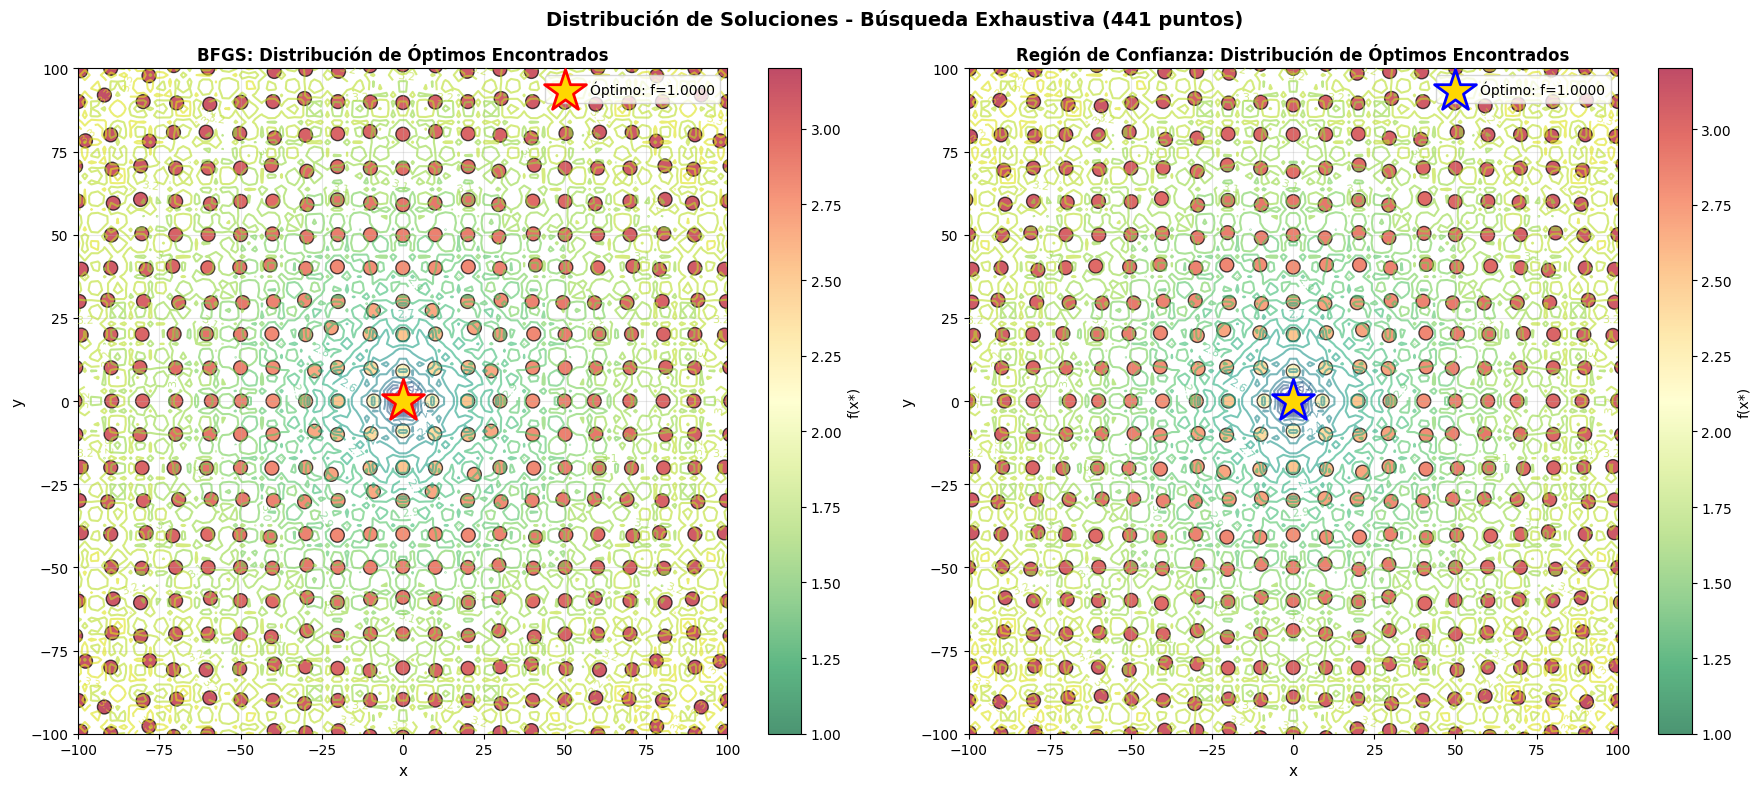

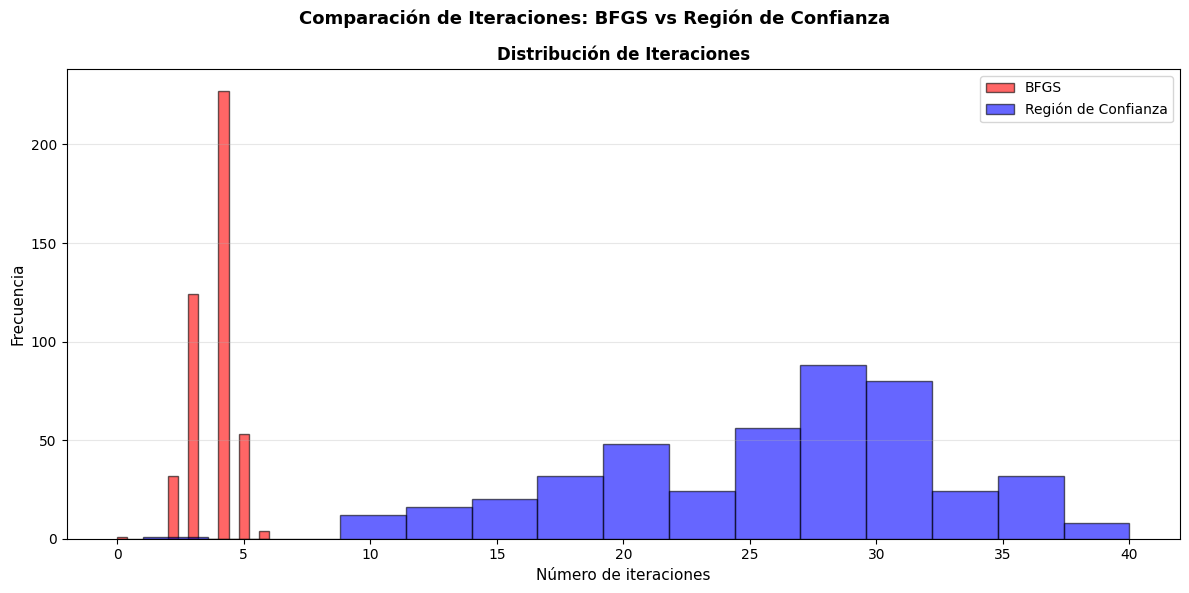

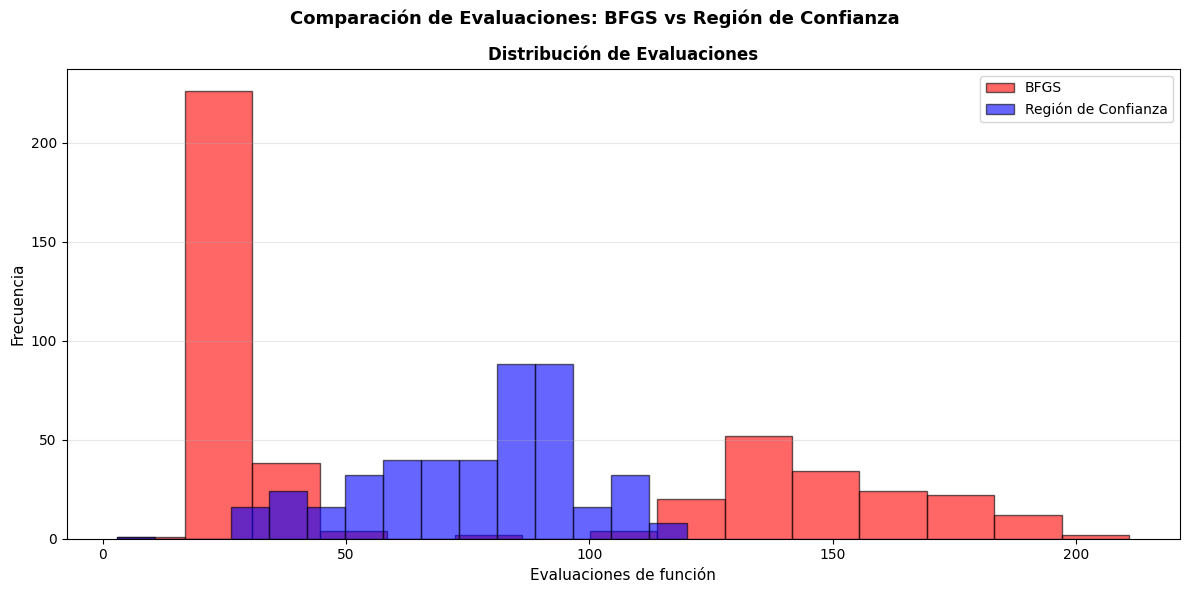

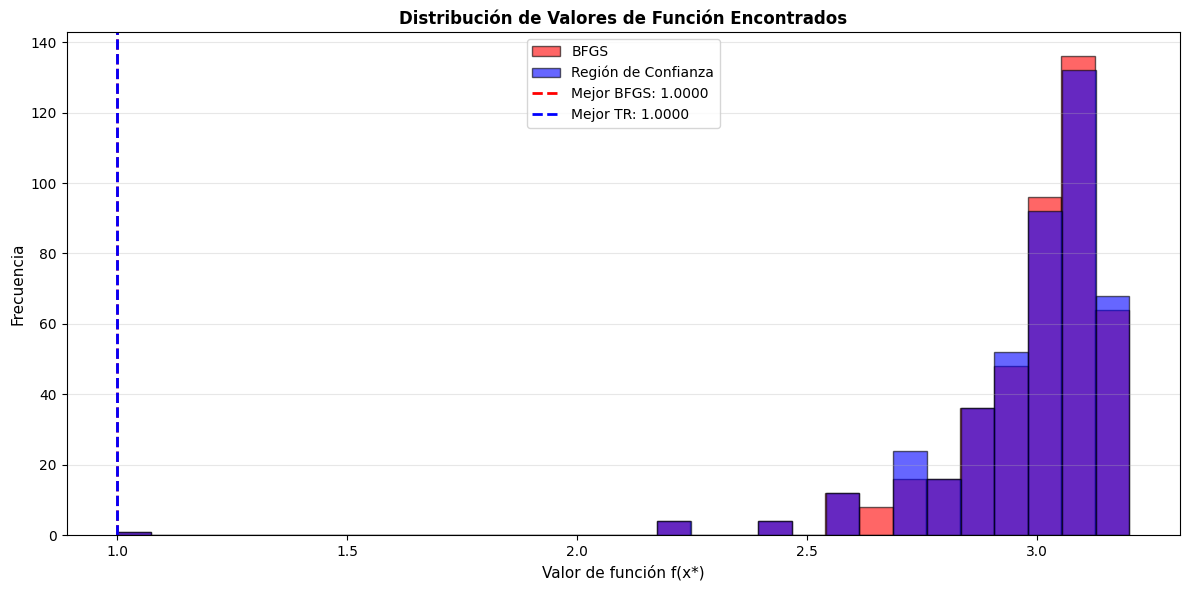

In [8]:
# Crear rango para contorno
x_range = np.linspace(-100, 100, 100)
y_range = np.linspace(-100, 100, 100)
X_cont, Y_cont = np.meshgrid(x_range, y_range)
Z_cont = np.zeros_like(X_cont)

for i in range(len(x_range)):
    for j in range(len(y_range)):
        Z_cont[j, i] = f(np.array([X_cont[j, i], Y_cont[j, i]]))

# Distribución de soluciones - BFGS vs Región de Confianza
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Distribución de Soluciones - Búsqueda Exhaustiva (441 puntos)', 
             fontsize=14, fontweight='bold')

# Panel 1: Distribución BFGS
ax = axes[0]
contour = ax.contour(X_cont, Y_cont, Z_cont, levels=20, cmap='viridis', alpha=0.6)
ax.clabel(contour, inline=True, fontsize=8)

bfgs_x_opt = np.array([x for _, x, _ in bfgs_solutions])
bfgs_f_vals = np.array([f_val for _, _, f_val in bfgs_solutions])

scatter1 = ax.scatter(bfgs_x_opt[:, 0], bfgs_x_opt[:, 1], c=bfgs_f_vals, 
                      cmap='RdYlGn_r', s=100, alpha=0.7, edgecolors='black', linewidth=1)
ax.scatter([best_bfgs_x[0]], [best_bfgs_x[1]], marker='*', s=1000, 
          color='gold', edgecolors='red', linewidth=2, label=f'Óptimo: f={best_bfgs_f:.4f}', zorder=5)
ax.set_xlabel('x', fontsize=11)
ax.set_ylabel('y', fontsize=11)
ax.set_title('BFGS: Distribución de Óptimos Encontrados', fontsize=12, fontweight='bold')
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.grid(True, alpha=0.3)
ax.legend()
cbar1 = plt.colorbar(scatter1, ax=ax)
cbar1.set_label('f(x*)', fontsize=10)

# Panel 2: Distribución Región de Confianza
ax = axes[1]
contour = ax.contour(X_cont, Y_cont, Z_cont, levels=20, cmap='viridis', alpha=0.6)
ax.clabel(contour, inline=True, fontsize=8)

tr_x_opt = np.array([x for _, x, _ in tr_solutions])
tr_f_vals = np.array([f_val for _, _, f_val in tr_solutions])

scatter2 = ax.scatter(tr_x_opt[:, 0], tr_x_opt[:, 1], c=tr_f_vals, 
                      cmap='RdYlGn_r', s=100, alpha=0.7, edgecolors='black', linewidth=1)
ax.scatter([best_tr_x[0]], [best_tr_x[1]], marker='*', s=1000, 
          color='gold', edgecolors='blue', linewidth=2, label=f'Óptimo: f={best_tr_f:.4f}', zorder=5)
ax.set_xlabel('x', fontsize=11)
ax.set_ylabel('y', fontsize=11)
ax.set_title('Región de Confianza: Distribución de Óptimos Encontrados', fontsize=12, fontweight='bold')
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.grid(True, alpha=0.3)
ax.legend()
cbar2 = plt.colorbar(scatter2, ax=ax)
cbar2.set_label('f(x*)', fontsize=10)

plt.tight_layout()
plt.show()

# Histogramas de Iteraciones
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Comparación de Iteraciones: BFGS vs Región de Confianza', 
             fontsize=13, fontweight='bold')
ax.hist(bfgs_nits, bins=15, alpha=0.6, label='BFGS', color='red', edgecolor='black')
ax.hist(tr_nits, bins=15, alpha=0.6, label='Región de Confianza', color='blue', edgecolor='black')
ax.set_xlabel('Número de iteraciones', fontsize=11)
ax.set_ylabel('Frecuencia', fontsize=11)
ax.set_title('Distribución de Iteraciones', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Histograma de evaluaciones
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Comparación de Evaluaciones: BFGS vs Región de Confianza', 
             fontsize=13, fontweight='bold')
ax.hist(bfgs_nfevs, bins=15, alpha=0.6, label='BFGS', color='red', edgecolor='black')
ax.hist(tr_nfevs, bins=15, alpha=0.6, label='Región de Confianza', color='blue', edgecolor='black')
ax.set_xlabel('Evaluaciones de función', fontsize=11)
ax.set_ylabel('Frecuencia', fontsize=11)
ax.set_title('Distribución de Evaluaciones', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Histograma de valores de función
fig, ax = plt.subplots(figsize=(12, 6))
bins = 30
ax.hist(bfgs_f_values, bins=bins, alpha=0.6, label='BFGS', color='red', edgecolor='black')
ax.hist(tr_f_values, bins=bins, alpha=0.6, label='Región de Confianza', color='blue', edgecolor='black')
ax.axvline(best_bfgs_f, color='red', linestyle='--', linewidth=2, label=f'Mejor BFGS: {best_bfgs_f:.4f}')
ax.axvline(best_tr_f, color='blue', linestyle='--', linewidth=2, label=f'Mejor TR: {best_tr_f:.4f}')
ax.set_xlabel('Valor de función f(x*)', fontsize=11)
ax.set_ylabel('Frecuencia', fontsize=11)
ax.set_title('Distribución de Valores de Función Encontrados', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## Visualización de Superficie en 3D del modelo y Curvas de Nivel

Graficación para un análisis visual de resultados.

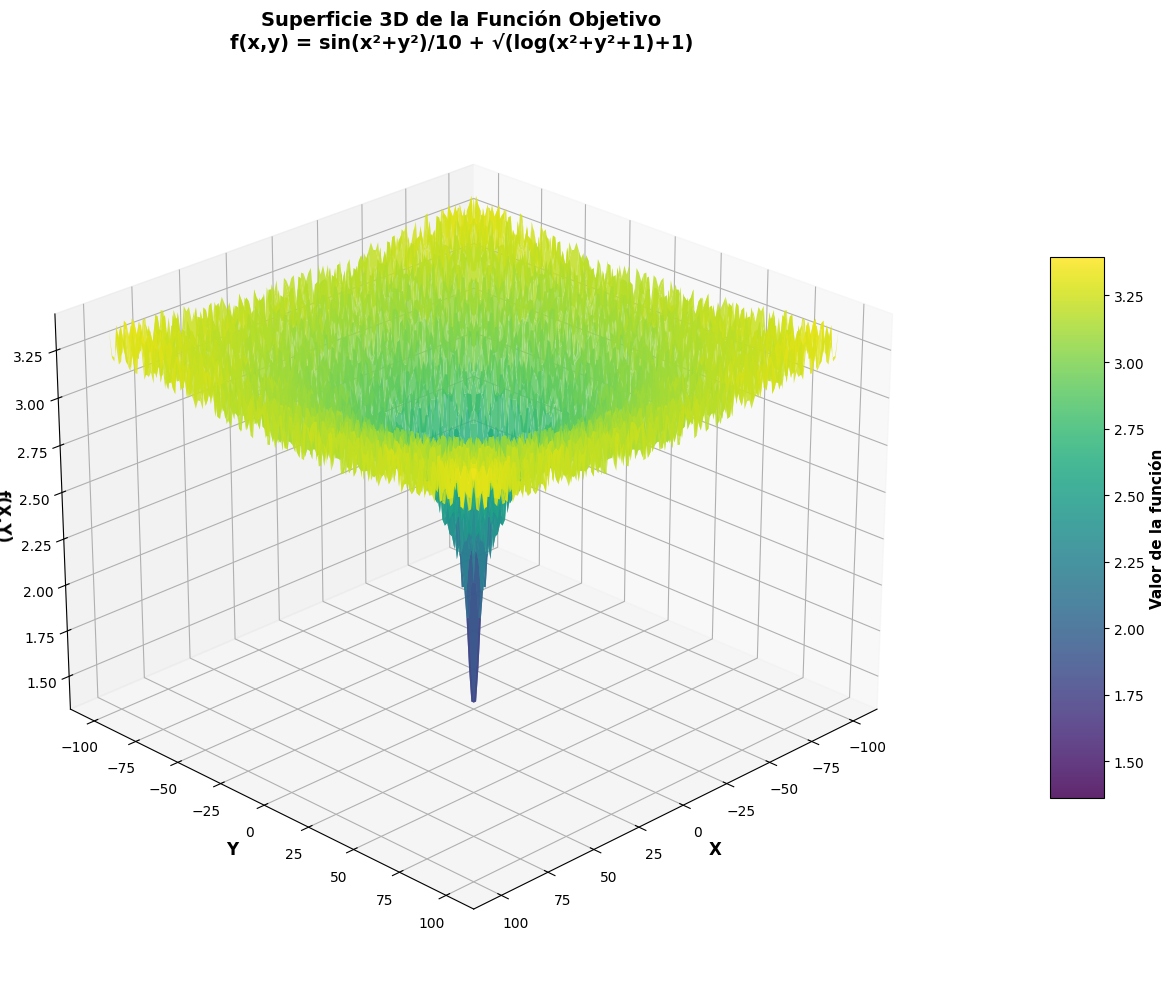

In [9]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Crear malla para la superficie con resolución optimizada
x = np.linspace(-100, 100, 150)
y = np.linspace(-100, 100, 150)
X, Y = np.meshgrid(x, y)

# Calcular valores de la función
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = f(np.array([X[i, j], Y[i, j]]))

# Graficar superficie con mapa de colores viridis
surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.85, 
                       linewidth=0, antialiased=True, 
                       vmin=Z.min(), vmax=Z.max())

# Personalización del gráfico
ax.set_xlabel('X', fontsize=12, fontweight='bold')
ax.set_ylabel('Y', fontsize=12, fontweight='bold')
ax.set_zlabel('f(X,Y)', fontsize=12, fontweight='bold')
ax.set_title('Superficie 3D de la Función Objetivo\nf(x,y) = sin(x²+y²)/10 + √(log(x²+y²+1)+1)', 
             fontsize=14, fontweight='bold', pad=20)

# Añadir barra de color
cbar = plt.colorbar(surf, ax=ax, shrink=0.6, aspect=10, pad=0.1)
cbar.set_label('Valor de la función', fontsize=11, fontweight='bold')

# Ajustes de vista
ax.view_init(elev=25, azim=45)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

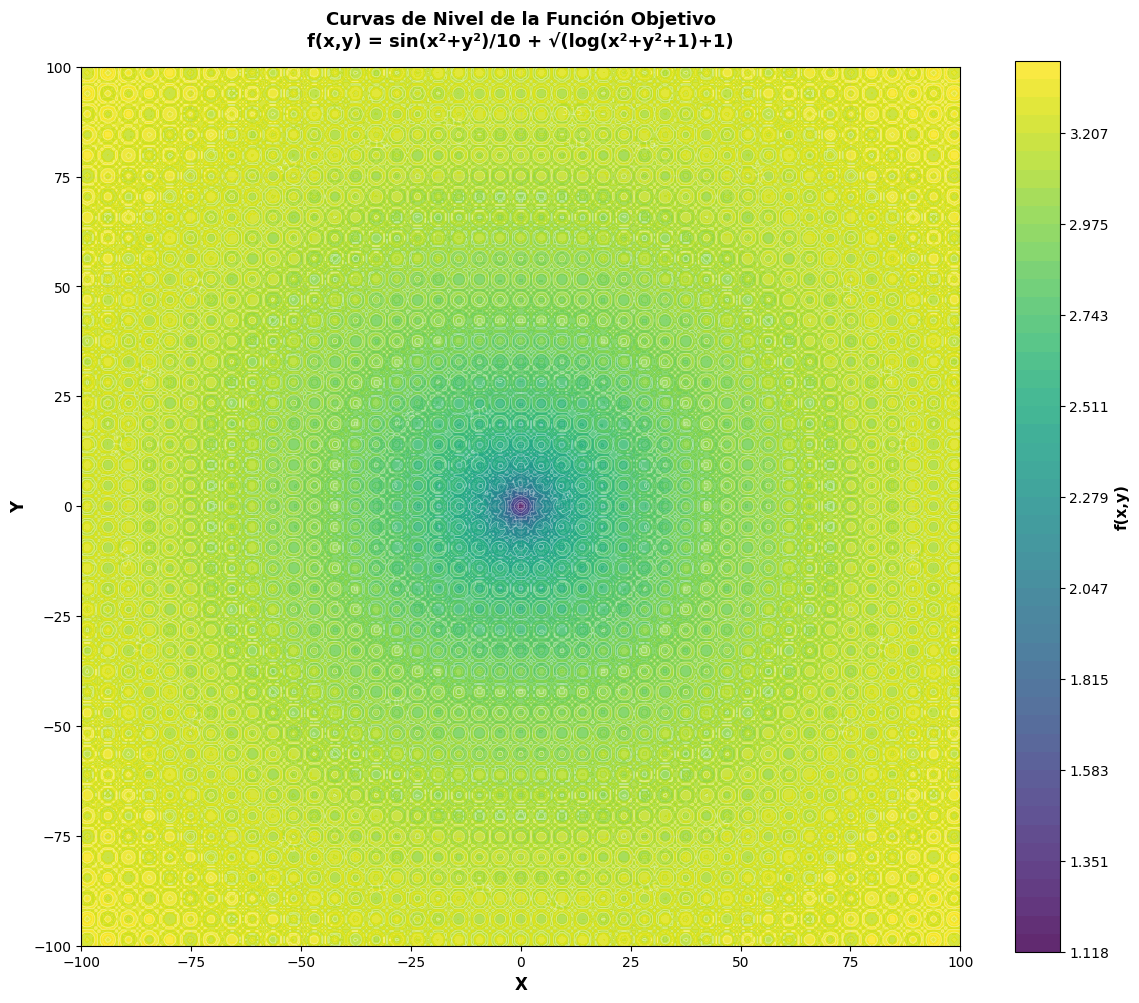

In [ ]:
# Graficación de Curvas de Nivel
fig, ax = plt.subplots(figsize=(12, 10))

# Crear malla para contornos
x = np.linspace(-100, 100, 300)
y = np.linspace(-100, 100, 300)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = f(np.array([X[i, j], Y[i, j]]))

# Crear mapa de contornos rellenos
levels = np.linspace(Z.min(), Z.max(), 50)
contourf = ax.contourf(X, Y, Z, levels=levels, cmap='viridis', alpha=0.85)

# Añadir líneas de contorno
contour_lines = ax.contour(X, Y, Z, levels=20, colors='white', 
                           alpha=0.4, linewidths=0.7)
ax.clabel(contour_lines, inline=True, fontsize=7, fmt='%.2f')

# Personalización
ax.set_xlabel('X', fontsize=12, fontweight='bold')
ax.set_ylabel('Y', fontsize=12, fontweight='bold')
ax.set_title('Curvas de Nivel de la Función Objetivo\nf(x,y) = sin(x²+y²)/10 + √(log(x²+y²+1)+1)', 
             fontsize=13, fontweight='bold', pad=15)

# Barra de color
cbar = plt.colorbar(contourf, ax=ax, label='Valor de la función')
cbar.set_label('f(x,y)', fontsize=11, fontweight='bold')

# Límites y grid
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.grid(True, alpha=0.2, linestyle='--')
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

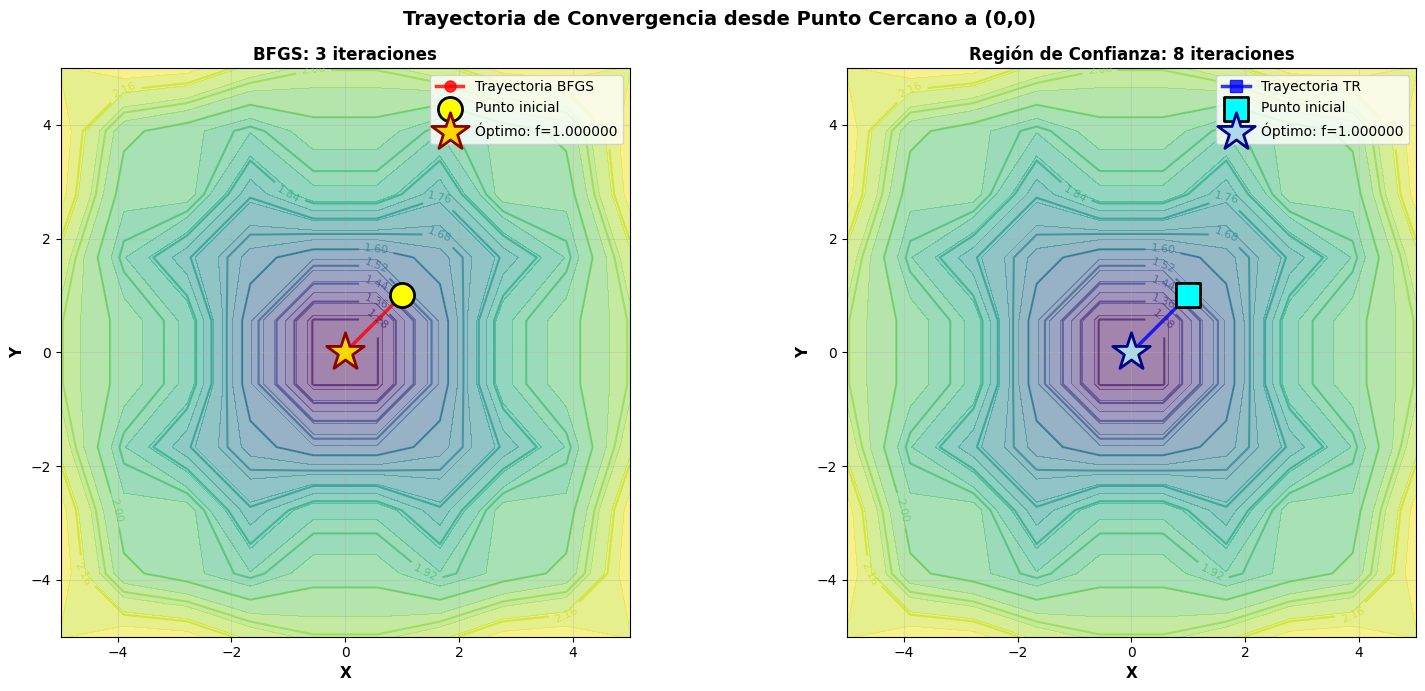

In [14]:
# Graficación de Trayectoria de Convergencia desde un Punto Cercano a (0,0)
x0_near_origin = np.array([1.0, 1.0])

x_mesh = np.linspace(-5, 5, 10)
y_mesh = np.linspace(-5, 5, 10)
X_mesh, Y_mesh = np.meshgrid(x_mesh, y_mesh)
Z_mesh = np.zeros_like(X_mesh)

for i in range(X_mesh.shape[0]):
    for j in range(X_mesh.shape[1]):
        Z_mesh[i, j] = f(np.array([X_mesh[i, j], Y_mesh[i, j]]))

# Ejecutar BFGS con tracking
positions_bfgs = [x0_near_origin.copy()]

def callback_bfgs(xk):
    positions_bfgs.append(xk.copy())

result_bfgs = minimize(f, x0_near_origin, method='BFGS', callback=callback_bfgs, 
                       options={'disp': False})

# Ejecutar Región de Confianza sin callback (más estable)
result_tr = minimize(f, x0_near_origin, method='trust-constr', 
                     options={'verbose': 0})

# Crear figura
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Trayectoria de Convergencia desde Punto Cercano a (0,0)', 
             fontsize=14, fontweight='bold')

# Panel 1: BFGS
ax = axes[0]
contour_bfgs = ax.contour(X_mesh, Y_mesh, Z_mesh, levels=15, cmap='viridis', alpha=0.7)
ax.clabel(contour_bfgs, inline=True, fontsize=8)
contourf_bfgs = ax.contourf(X_mesh, Y_mesh, Z_mesh, levels=20, cmap='viridis', alpha=0.5)

# Plotear trayectoria BFGS
positions_bfgs_array = np.array(positions_bfgs)
ax.plot(positions_bfgs_array[:, 0], positions_bfgs_array[:, 1], 'o-', linewidth=2.5, 
        markersize=8, color='red', alpha=0.8, label='Trayectoria BFGS')

# Punto inicial
ax.scatter([x0_near_origin[0]], [x0_near_origin[1]], marker='o', s=300, 
           color='yellow', edgecolors='black', linewidth=2, zorder=5, label='Punto inicial')

# Óptimo encontrado
ax.scatter([result_bfgs.x[0]], [result_bfgs.x[1]], marker='*', s=800, 
           color='gold', edgecolors='darkred', linewidth=2, zorder=5, 
           label=f'Óptimo: f={result_bfgs.fun:.6f}')

ax.set_xlabel('X', fontsize=11, fontweight='bold')
ax.set_ylabel('Y', fontsize=11, fontweight='bold')
ax.set_title(f'BFGS: {len(positions_bfgs_array)-1} iteraciones', fontsize=12, fontweight='bold')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10, loc='upper right')
ax.set_aspect('equal')

# Panel 2: Región de Confianza
ax = axes[1]
contour_tr = ax.contour(X_mesh, Y_mesh, Z_mesh, levels=15, cmap='viridis', alpha=0.7)
ax.clabel(contour_tr, inline=True, fontsize=8)
contourf_tr = ax.contourf(X_mesh, Y_mesh, Z_mesh, levels=20, cmap='viridis', alpha=0.5)

# Crear puntos de la trayectoria (aproximada) para TR
ax.plot([x0_near_origin[0], result_tr.x[0]], [x0_near_origin[1], result_tr.x[1]], 
        's-', linewidth=2.5, markersize=8, color='blue', alpha=0.8, label='Trayectoria TR')

# Punto inicial
ax.scatter([x0_near_origin[0]], [x0_near_origin[1]], marker='s', s=300, 
           color='cyan', edgecolors='black', linewidth=2, zorder=5, label='Punto inicial')

# Óptimo encontrado
ax.scatter([result_tr.x[0]], [result_tr.x[1]], marker='*', s=800, 
           color='lightblue', edgecolors='darkblue', linewidth=2, zorder=5, 
           label=f'Óptimo: f={result_tr.fun:.6f}')

ax.set_xlabel('X', fontsize=11, fontweight='bold')
ax.set_ylabel('Y', fontsize=11, fontweight='bold')
ax.set_title(f'Región de Confianza: {result_tr.nit} iteraciones', fontsize=12, fontweight='bold')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10, loc='upper right')
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

### Resumen de comparaciones entre ambos algoritmos

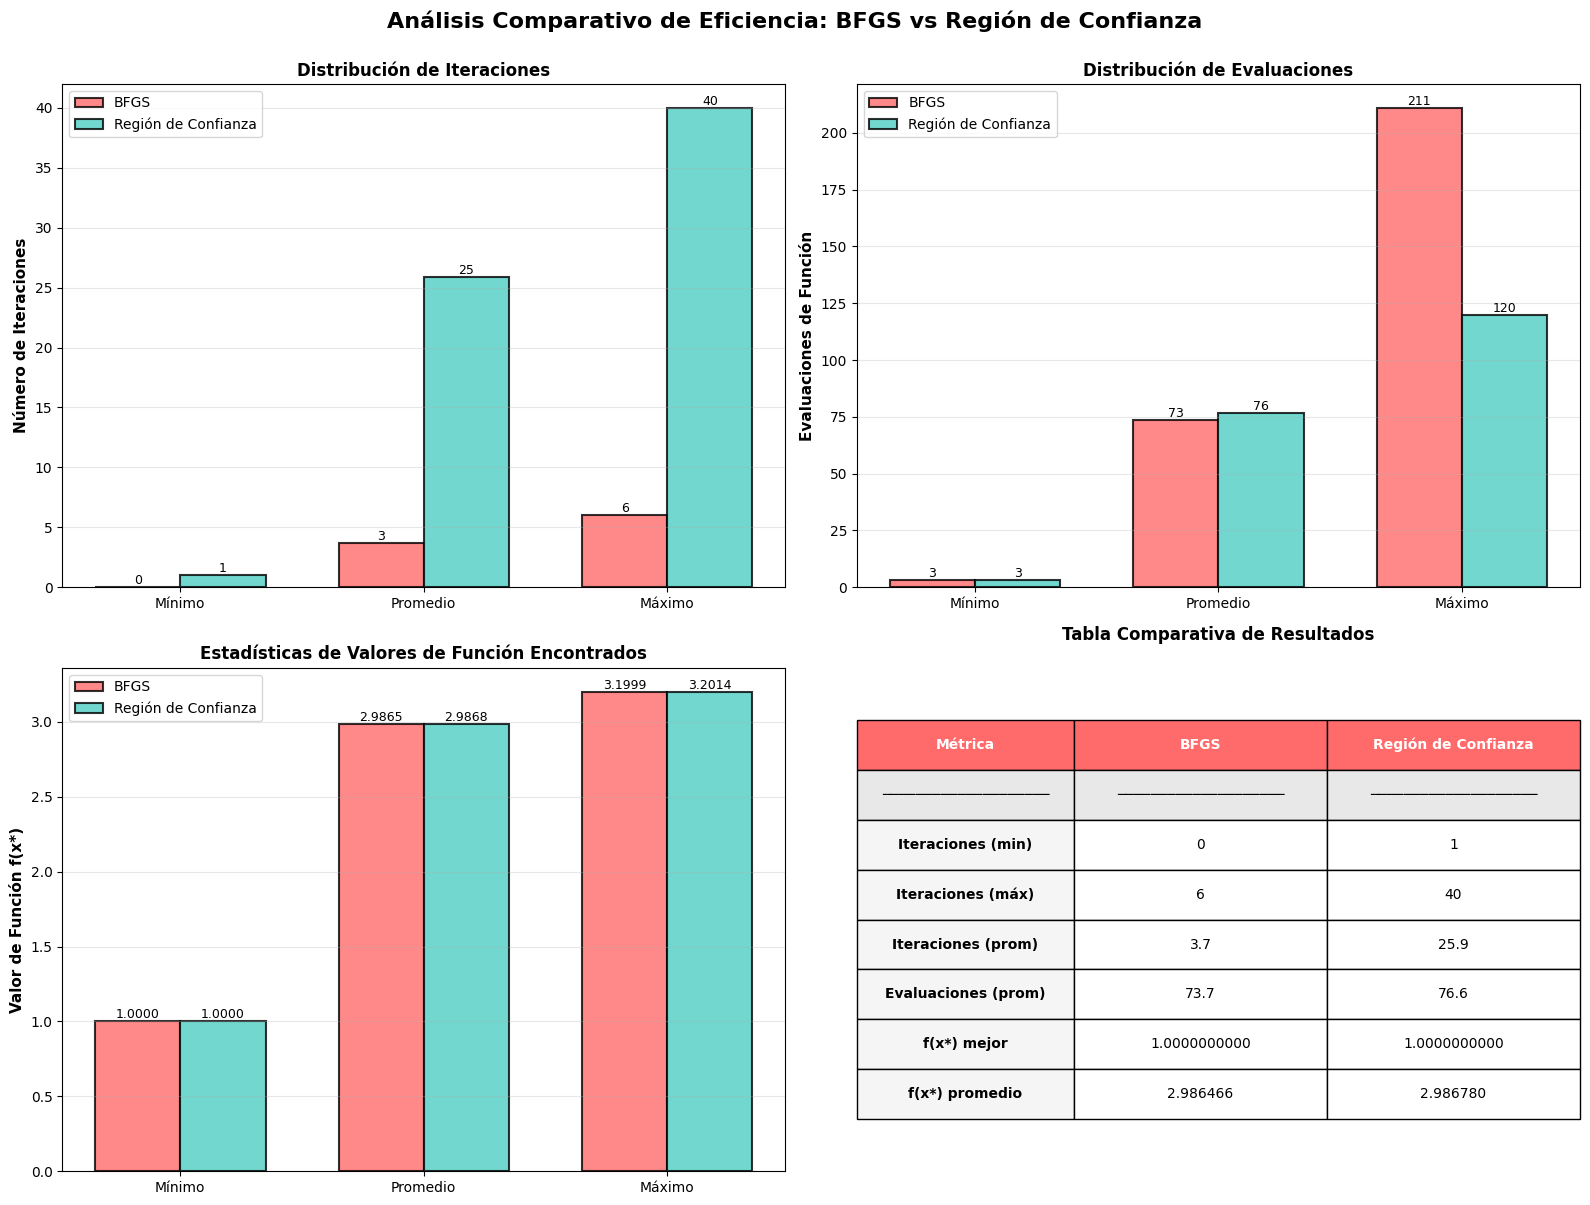

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis Comparativo de Eficiencia: BFGS vs Región de Confianza', 
             fontsize=16, fontweight='bold', y=1.00)

# Panel 1: Iteraciones
ax = axes[0, 0]
positions = np.arange(2)
widths = 0.35

bfgs_stats = [np.min(bfgs_nits), np.mean(bfgs_nits), np.max(bfgs_nits)]
tr_stats = [np.min(tr_nits), np.mean(tr_nits), np.max(tr_nits)]

x_labels = ['Mínimo', 'Promedio', 'Máximo']
x_pos = np.arange(len(x_labels))

bars1 = ax.bar(x_pos - widths/2, bfgs_stats, widths, label='BFGS', 
              color='#FF6B6B', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x_pos + widths/2, tr_stats, widths, label='Región de Confianza', 
              color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_ylabel('Número de Iteraciones', fontsize=11, fontweight='bold')
ax.set_title('Distribución de Iteraciones', fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{int(height)}', ha='center', va='bottom', fontsize=9)

# Panel 2: Evaluaciones de función
ax = axes[0, 1]

bfgs_eval_stats = [np.min(bfgs_nfevs), np.mean(bfgs_nfevs), np.max(bfgs_nfevs)]
tr_eval_stats = [np.min(tr_nfevs), np.mean(tr_nfevs), np.max(tr_nfevs)]

bars1 = ax.bar(x_pos - widths/2, bfgs_eval_stats, widths, label='BFGS', 
              color='#FF6B6B', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x_pos + widths/2, tr_eval_stats, widths, label='Región de Confianza', 
              color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_ylabel('Evaluaciones de Función', fontsize=11, fontweight='bold')
ax.set_title('Distribución de Evaluaciones', fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{int(height)}', ha='center', va='bottom', fontsize=9)

# Panel 3: Valores de función encontrados
ax = axes[1, 0]

bfgs_f_stats = [np.min(bfgs_f_values), np.mean(bfgs_f_values), np.max(bfgs_f_values)]
tr_f_stats = [np.min(tr_f_values), np.mean(tr_f_values), np.max(tr_f_values)]

bars1 = ax.bar(x_pos - widths/2, bfgs_f_stats, widths, label='BFGS', 
              color='#FF6B6B', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x_pos + widths/2, tr_f_stats, widths, label='Región de Confianza', 
              color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_ylabel('Valor de Función f(x*)', fontsize=11, fontweight='bold')
ax.set_title('Estadísticas de Valores de Función Encontrados', fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Panel 4: Matriz de comparación textual
ax = axes[1, 1]
ax.axis('off')

# Crear tabla de comparación
comparison_data = [
    ['Métrica', 'BFGS', 'Región de Confianza'],
    ['─' * 20, '─' * 20, '─' * 20],
    ['Iteraciones (min)', f'{min(bfgs_nits)}', f'{min(tr_nits)}'],
    ['Iteraciones (máx)', f'{max(bfgs_nits)}', f'{max(tr_nits)}'],
    ['Iteraciones (prom)', f'{np.mean(bfgs_nits):.1f}', f'{np.mean(tr_nits):.1f}'],
    ['Evaluaciones (prom)', f'{np.mean(bfgs_nfevs):.1f}', f'{np.mean(tr_nfevs):.1f}'],
    ['f(x*) mejor', f'{min(bfgs_f_values):.10f}', f'{min(tr_f_values):.10f}'],
    ['f(x*) promedio', f'{np.mean(bfgs_f_values):.6f}', f'{np.mean(tr_f_values):.6f}'],
]

# Crear tabla
table = ax.table(cellText=comparison_data, cellLoc='center', loc='center',
                colWidths=[0.3, 0.35, 0.35])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Personalizar tabla
for i in range(len(comparison_data)):
    for j in range(3):
        cell = table[(i, j)]
        if i == 0:  # Encabezado
            cell.set_facecolor('#FF6B6B')
            cell.set_text_props(weight='bold', color='white')
        elif i == 1:  # Separador
            cell.set_facecolor('#E8E8E8')
        else:
            if j == 0:
                cell.set_facecolor('#F5F5F5')
                cell.set_text_props(weight='bold')
            else:
                cell.set_facecolor('#FFFFFF')

ax.set_title('Tabla Comparativa de Resultados', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()